# Overfitting and Regularization

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn import set_config

In [3]:
set_config(display='diagram')

## Settings

In [4]:
SEED = 42
RANGE = (-5, 5)
N_SAMPLES = 50
DEGREES = np.linspace(0, 15, 1 + 15, dtype=int)
ALPHAS = np.linspace(0, 0.5, 1 + 40)

## Part 1: Underfitting vs. overfitting

### Generate samples

Let's pick a target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ and generate some noisy samples to learn from.

In [5]:
def target_function(x):
    return 2 * x + 10 * np.sin(x)

def generate_samples():
    """Generate noisy samples."""
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    y = target_function(x) + np.random.normal(scale=4, size=N_SAMPLES)
    return x.reshape(-1, 1), y

X, y = generate_samples()

### Plot samples

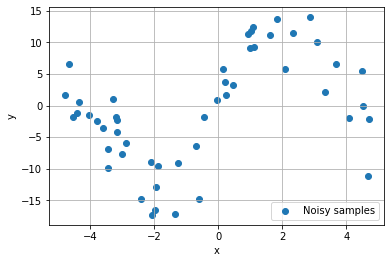

In [6]:
def plot_scatter(x, y, title=None, label='Noisy samples'):
    plt.scatter(x, y, label=label)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.title(title)
    plt.legend(loc='lower right')

plot_scatter(X, y)

### Split

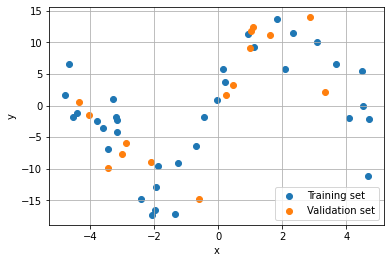

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)

plot_scatter(X_train, y_train, label='Training set')
plot_scatter(X_valid, y_valid, label='Validation set')

In [8]:
y_train

array([ -1.10771616,   0.84986647,  -9.62110024,   3.70972424,
        -2.36319095,   5.83708039, -16.53330524,  -1.8815588 ,
       -11.1506254 ,   1.0883081 ,  -9.05957818, -14.72254274,
         5.71746212,   5.48508317,  -6.81897956,  -1.80751907,
        -2.14124891, -12.83476672,  -0.09034969,  -3.48222266,
        11.50001273,  -2.03019037,  10.03142993, -17.18409407,
        -2.48182149,   1.67461593, -17.32081894,  -6.32825039,
        -4.15121484,   9.31494651,   6.5817456 ,   6.58351686,
        -1.83803375,  11.27589865,  13.68530977])

### Model

Let's try to approximate our target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ with polynomials of different degree. 

A polynomial of degree $n$ has the form:
$ h(x) = w_0 + w_1\cdot x + w_2\cdot x^2 +\ldots + w_n\cdot x^n $.

$x^i$ values could easily be generated by `PolynomialFeatures`, while $w_i$ are the unknown paramaters to be estimated using `LinearRegression`.

In [9]:
PolynomialFeatures(degree=4, include_bias=False).fit_transform(X=[
    [1],
    [3],
    [4],
])

array([[  1.,   1.,   1.,   1.],
       [  3.,   9.,  27.,  81.],
       [  4.,  16.,  64., 256.]])

In [10]:
def make_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree, include_bias=(degree == 0))),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

display(make_model(2))
display(make_model(2, penalty='L1', alpha=0.1))
display(make_model(2, penalty='L2', alpha=0.1))

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()), ('reg', LinearRegression())])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Lasso(alpha=0.1, max_iter=50000, random_state=42))])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Ridge(alpha=0.1, max_iter=50000, random_state=42))])

### Fit

Let's fit a model and plot the hypothesis it learns:

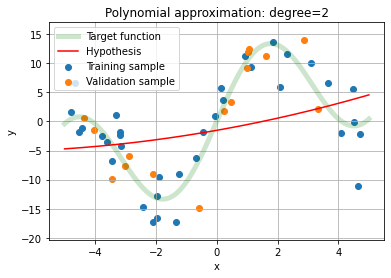

In [11]:
def plot_fit(model):
    degree = model['pol'].degree
    X_range = np.linspace(*RANGE, 1000).reshape(-1, 1)
    y_pred = model.predict(X_range)
    plot_scatter(X_train, y_train, label='Training sample')
    plot_scatter(X_valid, y_valid, label='Validation sample')
    plt.plot(X_range, target_function(X_range), c='green', alpha=0.2, lw=5, label='Target function')
    plt.plot(X_range, y_pred, c='red', label='Hypothesis')
    plt.ylim((min(y) - 3, max(y) + 3))
    plt.legend(loc='best')    
    plt.title(f'Polynomial approximation: degree={degree}')
    plt.show()

plot_fit(make_model(degree=2).fit(X_train, y_train))

### From underfitting to overfitting

We can investigate the shape of the fitted curve for different values of `degree`:

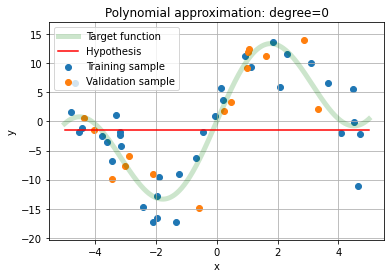

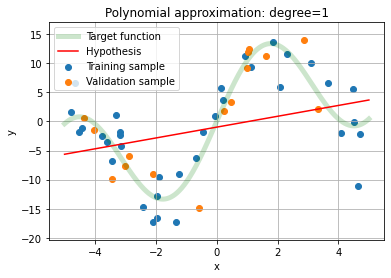

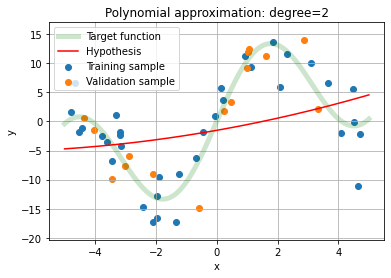

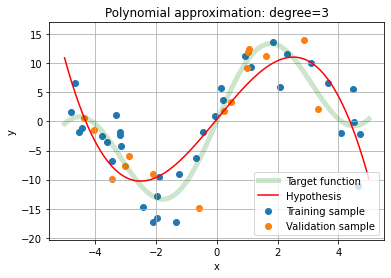

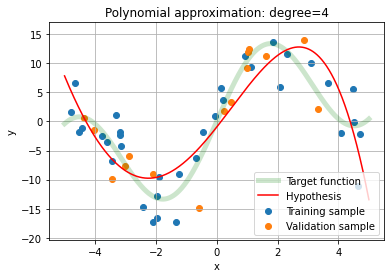

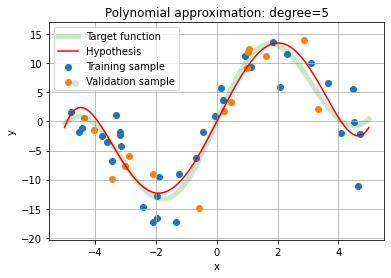

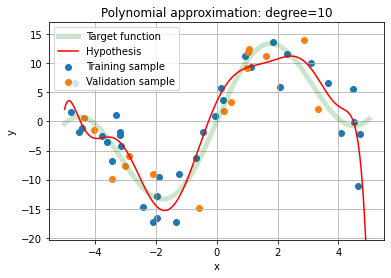

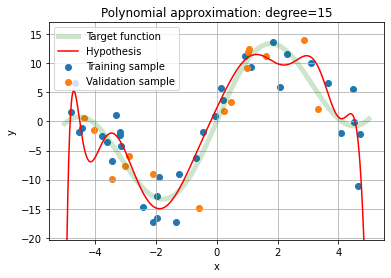

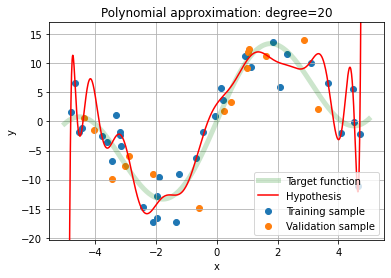

In [12]:
for degree in [0, 1, 2, 3, 4, 5, 10, 15, 20]:
    plot_fit(make_model(degree).fit(X_train, y_train))

### Fitting graph

In the next step we calculate the training and the validation error for each `degree` and plot them in a single graph. The resulting graph is called the fitting graph.

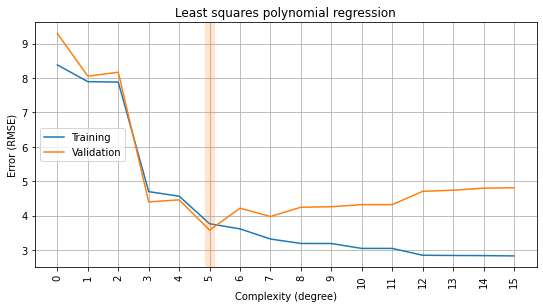

In [13]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, 
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph'):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')        
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='center right')         
    plt.show()
    
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

### Sweet spot

What is the optimal `degree` to go with?

In [14]:
DEGREES[np.argmin(rmse_valid)]

5

### Cross-validation

Ideally, we would choose the the model parameters such that we have the best model performance. However, we want to make sure that we really have the best validation performance. When we do `train_test_split` we randomly split the data into two parts. What could happen is that we got lucky and split the data such that it favours the validation error. This is especially dangerous if we are dealing with small datasets. One way to check if that's the case is to run the experiment several times for different, random splits. However, there is an even more systematic way of doing this: [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=50% />

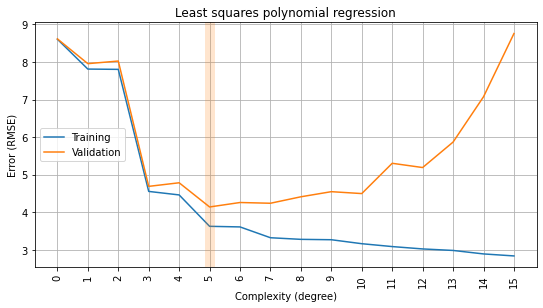

In [15]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

### Model coefficients

Let's inspect our regression model coefficients:

In [16]:
(make_model(degree=1).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=2).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=5).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=10).fit(X_train, y_train)['reg'].coef_)

(array([2.81292778]),
 array([2.80049884, 0.45166501]),
 array([ 30.87315584,   1.48752361, -54.60227825,  -1.63699842,
         26.62792933]),
 array([  33.63850705,  -41.86346242,  -70.48743112,  278.98853452,
          27.48125634, -656.36383501,   59.32988346,  651.64795186,
         -47.55728814, -233.48455138]))

Hmm... it looks like high degree polynomials are coming with much bigger regression coefficients. 

We are going to plot the mean absolute value of $w_i$ as a function of degree to reveal the relationship:

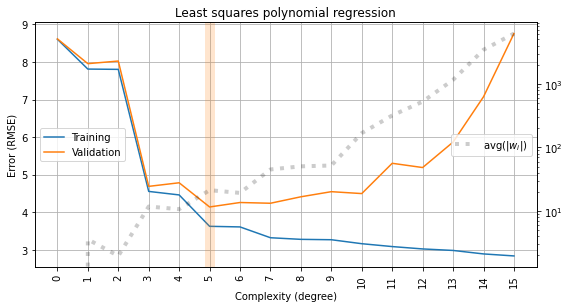

In [17]:
rmse_train, rmse_valid, avg_coef = [], [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree),
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

### Summary

We observe the following:

1. **Underfitting** (degree < 5): The model is not able to fit the data properly. The fit is bad for both the training and the validation set.

2. **Fit is just right** (degree = 5): The model is able to capture the underlying data distribution. The fit is good for both the training and the validation set.

3. **Overfitting** (degree > 5): The model starts fitting the noise in the dataset. While the fit for the training data gets even better, the fit for the validation set gets worse.

4. As the order of polynomial increases, the linear model coefficients become more likely to take on **large values**.

## Part 2: Regularization

There are two major ways to build a machine learning model with the ability to generalize well on unseen data:
1. Train the simplest model possible for our purpose (according to Occam’s Razor).
2. Train a complex or more expressive model on the data and perform regularization.

Regularization is a method used to reduce the variance of a machine learning model. In other words, it is used to reduce overfitting. Regularization penalizes a model for being complex. For linear models, it means regularization forces model coefficients to be smaller in magnitude.

Let's pick a polynomial model of degree **15** (which tends to overfit strongly) and try to regularize it using **L1** and **L2** penalties.

### L1 - Lasso regression

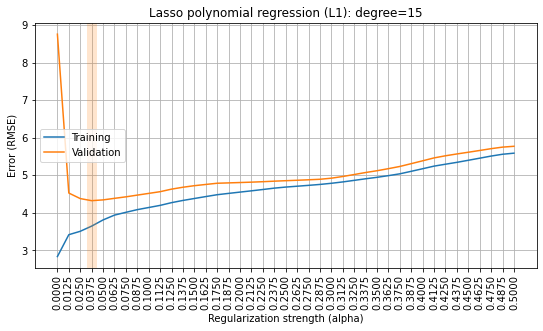

In [18]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

### L2 - Ridge regression

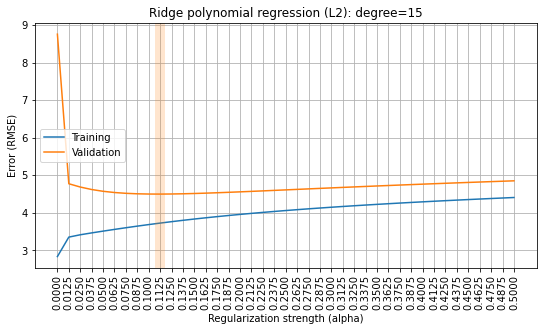

In [19]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=15')

### Summary

1. We can control the regularization strength by changing the hyperparameter `alpha`.
2. Regularized version of the model performs pretty well. Even in case the original original (unregularized) model is heavily overfitting due to excessive complexity.

## Part 3: Homework assignment (10 points)

**WARNING!**

Due to the limited power of your machine, you may face some difficulties in generating polynomial features of a high degree. It's ok to take only a subsample of features for that purpose (even one feature is enough). Afterwards, you **must collect all features together** (those which were used to generate polynomials and the rest).

### Excercise 1 - Overfiting and Underfitting (2 points)

Let's work with the diabetes dataset

In [20]:
from sklearn.datasets import load_diabetes
data = load_diabetes()
X_diabetes = pd.DataFrame(data['data'], columns=data['feature_names'])
y_diabetes = pd.DataFrame(data['target'], columns=['target'])
print(data['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

*It was interesting for me to see the correlation between features. There are two highly correlated features - s1 and s2*

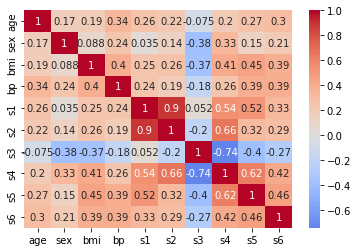

In [21]:
sns.heatmap(pd.DataFrame.corr(X_diabetes), annot=True, center=0, cmap='coolwarm');

Apply model for diabetes dataset with polynomial feature engineering of different degrees. Plot the dependence of train and test error on polynomial degree. Highlight a degree with the best test error. Which degrees cause overfitting/underfitting? Why?

*Let's split the dataset into train and test parts and show the dependency of train and test error for the degrees from 1 to 10*

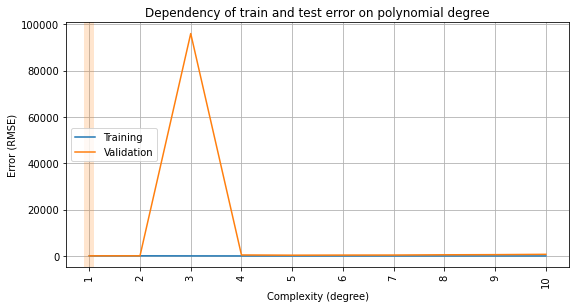

In [22]:
# your findings/conclusions
X_train, X_valid, y_train, y_valid = train_test_split(X_diabetes, y_diabetes, test_size=0.3, random_state=SEED)

rmse_train, rmse_valid = [], []
list_of_degrees = [i for i in range(1, 11)]
for degree in DEGREES[1:11:]:#list_of_degrees:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES[1:11:], rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Dependency of train and test error on polynomial degree')

*RMSE for the degree=3 is very big, so it seems like RMSE's for other ones are close to 0. Let's remove 3 from the degrees list and make the plot again*

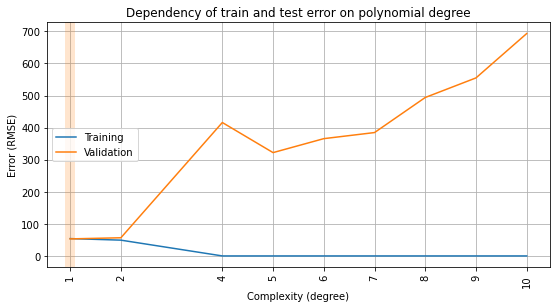

In [23]:
# your findings/conclusions
X_train, X_valid, y_train, y_valid = train_test_split(X_diabetes, y_diabetes, test_size=0.3, random_state=SEED)

rmse_train, rmse_valid = [], []
list_of_degrees = [i for i in range(1, 11)]
list_of_degrees.remove(3)
for degree in list_of_degrees:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(list_of_degrees, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Dependency of train and test error on polynomial degree')

*This plot demonstrates the dependency more clearly*

*Now let's split the initial dataset into 2 parts, polynomize them, join and do the same operations as in the cells above for all the degrees*

In [24]:
list_of_features = ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

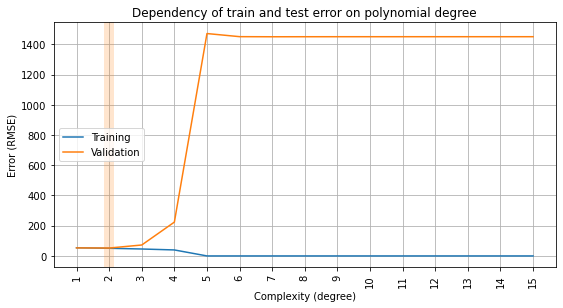

In [25]:
# your findings/conclusions
rmse_train, rmse_valid = [], []
list_of_degrees = [i for i in range(1, 16)]
for degree in DEGREES[1::]:
    X_diabetes_part_1_polynomial = PolynomialFeatures(degree).fit_transform(X_diabetes[list_of_features[:5:]])
    X_diabetes_part_2_polynomial = PolynomialFeatures(degree).fit_transform(X_diabetes[list_of_features[5::]])
    X_diabetes_polynomial_full = np.concatenate((X_diabetes_part_1_polynomial, X_diabetes_part_2_polynomial), axis=1)

    X_train, X_valid, y_train, y_valid = train_test_split(X_diabetes_polynomial_full, y_diabetes, test_size=0.3, random_state=SEED)

    reg = LinearRegression().fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES[1::], rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Dependency of train and test error on polynomial degree')

*And the last variant is cross-validation, I did it for the degrees from 1 to 7*

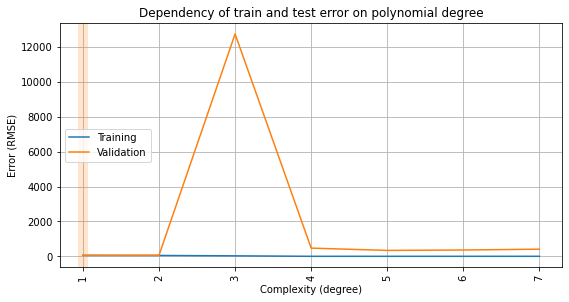

In [26]:
rmse_train, rmse_valid = [], []
list_of_degrees = [i for i in range(1, 8)]
for degree in DEGREES[1:8:]:
    results = cross_validate(make_model(degree), 
                             X_diabetes, y_diabetes, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES[1:8:], rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Dependency of train and test error on polynomial degree')

 **Conclusion for task 1.**  *Degree=1 shows the best test error. Degrees from 2 cause overfitting because there are too many parts in the equation of our model. The results are a little bit different in case of partial polynomizing - the best error is shown on the degree=2, I think this depends on the particular choise of the feature splitting (I splitted 5:5).*

### Excercise 2 - Magnitude (3 points)

As discussed earlier, regularization methods are expected to constraint the weights (model coefficients). 

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

In [27]:
ALPHAS

array([0.    , 0.0125, 0.025 , 0.0375, 0.05  , 0.0625, 0.075 , 0.0875,
       0.1   , 0.1125, 0.125 , 0.1375, 0.15  , 0.1625, 0.175 , 0.1875,
       0.2   , 0.2125, 0.225 , 0.2375, 0.25  , 0.2625, 0.275 , 0.2875,
       0.3   , 0.3125, 0.325 , 0.3375, 0.35  , 0.3625, 0.375 , 0.3875,
       0.4   , 0.4125, 0.425 , 0.4375, 0.45  , 0.4625, 0.475 , 0.4875,
       0.5   ])

#### L1

*Let's count mean weight for each alpha*

In [28]:
weights_l1 = []
for alpha in ALPHAS:
    X_diabetes_part_1_polynomial = PolynomialFeatures(degree).fit_transform(X_diabetes[list_of_features[:5:]])
    X_diabetes_part_2_polynomial = PolynomialFeatures(degree).fit_transform(X_diabetes[list_of_features[5::]])
    X_diabetes_polynomial_full = np.concatenate((X_diabetes_part_1_polynomial, X_diabetes_part_2_polynomial), axis=1)

    X_train, X_valid, y_train, y_valid = train_test_split(X_diabetes_polynomial_full, y_diabetes, test_size=0.3, random_state=SEED)

    reg = Lasso(alpha=alpha, random_state=SEED, max_iter=50000).fit(X_train, y_train)
    weights_l1.append(np.mean(reg.coef_))

C:\Users\ognev\AppData\Local\Temp/ipykernel_20256/3983336376.py:9: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  reg = Lasso(alpha=alpha, random_state=SEED, max_iter=50000).fit(X_train, y_train)
C:\Users\ognev\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


*Here is the plot*

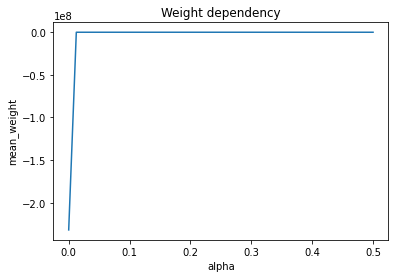

In [29]:
plt.plot(ALPHAS, weights_l1);
plt.xlabel('alpha')
plt.ylabel('mean_weight')
plt.title('Weight dependency');

*Looks like the weight for alpha=0 is much bigger than the others, let's see the plot without it*

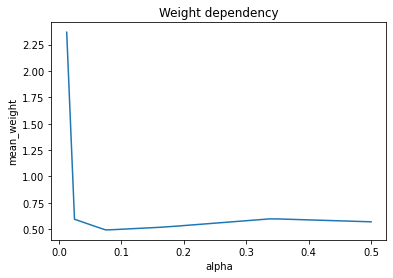

In [30]:
plt.plot(ALPHAS[1::], weights_l1[1::]);
plt.xlabel('alpha')
plt.ylabel('mean_weight')
plt.title('Weight dependency');

#### L2

*Let's count mean weight for each alpha*

In [31]:
weights_l2 = []
for alpha in ALPHAS:
    X_diabetes_part_1_polynomial = PolynomialFeatures(degree).fit_transform(X_diabetes[list_of_features[:5:]])
    X_diabetes_part_2_polynomial = PolynomialFeatures(degree).fit_transform(X_diabetes[list_of_features[5::]])
    X_diabetes_polynomial_full = np.concatenate((X_diabetes_part_1_polynomial, X_diabetes_part_2_polynomial), axis=1)

    X_train, X_valid, y_train, y_valid = train_test_split(X_diabetes_polynomial_full, y_diabetes, test_size=0.3, random_state=SEED)

    reg = Ridge(alpha=alpha, random_state=SEED, max_iter=50000).fit(X_train, y_train)
    weights_l2.append(np.mean(reg.coef_))

C:\Users\ognev\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


*Here is the plot*

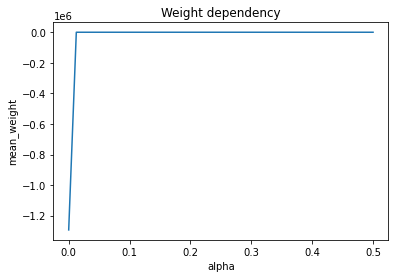

In [32]:
plt.plot(ALPHAS, weights_l2);
plt.xlabel('alpha')
plt.ylabel('mean_weight')
plt.title('Weight dependency');

*Looks like the weight for alpha=0 is much bigger than the others, let's see the plot without it*

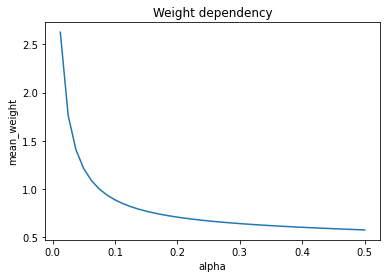

In [33]:
plt.plot(ALPHAS[1::], weights_l2[1::]);
plt.xlabel('alpha')
plt.ylabel('mean_weight')
plt.title('Weight dependency');

*This plot shows that when alpha increases, mean weight decreases*

#### Summary

*The last plots in L1 and L2 chapters clearly demonstrate that regularization methods constraint the weights (model coefficients), except the case alpha=0. Indeed, other mean weights don't exceed 3. Also for L2 we can see that when alpha increases, mean weight decreases. The plot for L2 is very similar to the upper part of the plot of the function y=k/x (hyperbola)*

### Excercise 3 - Sparsity (3 points)

Lasso can also be used for **feature selection** since L1 is [more likely to produce zero coefficients](https://explained.ai/regularization/).

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

*Let's count non-zero weights for each alpha*

In [34]:
## your code
weights_l1_nonzero = []
for alpha in ALPHAS:
    X_diabetes_part_1_polynomial = PolynomialFeatures(degree).fit_transform(X_diabetes[list_of_features[:5:]])
    X_diabetes_part_2_polynomial = PolynomialFeatures(degree).fit_transform(X_diabetes[list_of_features[5::]])
    X_diabetes_polynomial_full = np.concatenate((X_diabetes_part_1_polynomial, X_diabetes_part_2_polynomial), axis=1)

    X_train, X_valid, y_train, y_valid = train_test_split(X_diabetes_polynomial_full, y_diabetes, test_size=0.3, random_state=SEED)

    reg = Lasso(alpha=alpha, random_state=SEED, max_iter=50000).fit(X_train, y_train)
    weights_l1_nonzero.append(np.count_nonzero(reg.coef_))

C:\Users\ognev\AppData\Local\Temp/ipykernel_20256/5361168.py:10: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  reg = Lasso(alpha=alpha, random_state=SEED, max_iter=50000).fit(X_train, y_train)
C:\Users\ognev\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


*Here's the plot*

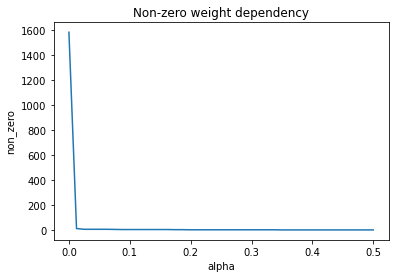

In [35]:
plt.plot(ALPHAS, weights_l1_nonzero);
plt.xlabel('alpha')
plt.ylabel('non_zero')
plt.title('Non-zero weight dependency');

*And again the plot for alphas without the first one*

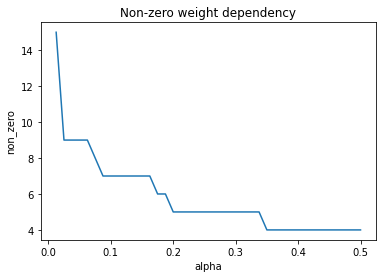

In [36]:
plt.plot(ALPHAS[1::], weights_l1_nonzero[1::]);
plt.xlabel('alpha')
plt.ylabel('non_zero')
plt.title('Non-zero weight dependency');

*The plot demonstrates that there are a lot of zeros among the coefficients. The amount of non-zero elements decreases while alpha increases.*

#### L2

In [37]:
## your code
weights_l2_nonzero = []
for alpha in ALPHAS:
    X_diabetes_part_1_polynomial = PolynomialFeatures(degree).fit_transform(X_diabetes[list_of_features[:5:]])
    X_diabetes_part_2_polynomial = PolynomialFeatures(degree).fit_transform(X_diabetes[list_of_features[5::]])
    X_diabetes_polynomial_full = np.concatenate((X_diabetes_part_1_polynomial, X_diabetes_part_2_polynomial), axis=1)

    X_train, X_valid, y_train, y_valid = train_test_split(X_diabetes_polynomial_full, y_diabetes, test_size=0.3, random_state=SEED)

    reg = Ridge(alpha=alpha, random_state=SEED, max_iter=50000).fit(X_train, y_train)
    weights_l2_nonzero.append(np.count_nonzero(reg.coef_))

C:\Users\ognev\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


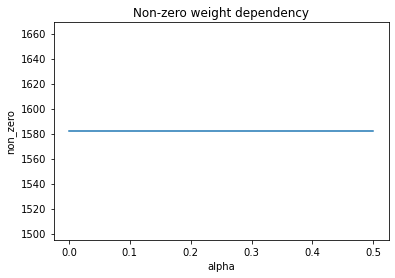

In [38]:
plt.plot(ALPHAS, weights_l2_nonzero);
plt.xlabel('alpha')
plt.ylabel('non_zero')
plt.title('Non-zero weight dependency');

In [39]:
set(weights_l2_nonzero)

{1582}

*The plot and the set demonstrate that there is constant number of non-zero elements for all alphas.*

#### Summary

*As plots show, L1 is really more likely to produce zero coefficients. Looks like all coefficients are non-zero in L2, but there are only few non-zero coefficients in L1 for each alpha (except alpha=0)*

### Excercise 4 - Scaling (2 points)

As a general rule, it is recommended to scale input features before fitting a regularized model so that the features/inputs take values in similar ranges. One common way of doing so is to standardize the inputs and that is exactly what our pipeline  second step (`StandardScaler`) is responsible for. 

Is scaling important? What are the underlying reasons?

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**) on the dataset below. Check coefficients.

In [40]:
def target_function_hw(x):
    return 2 * x

def generate_samples_hw():
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    
    np.random.seed(SEED+1)
    x_noise = np.random.uniform(*[x * 100 for x in RANGE], size=N_SAMPLES)
    x_noise2 = np.random.normal(100, 50, size=N_SAMPLES)
    
    y = target_function_hw(x) + np.random.normal(scale=4, size=N_SAMPLES)
    
    return np.concatenate([x.reshape(-1, 1) / 100, 
                           x_noise.reshape(-1, 1),
                           x_noise2.reshape(-1, 1)], axis=1), y

X_hw, y_hw = generate_samples_hw()

for i in range(X_hw.shape[1]):
    print(f'Min of feature {i}: {min(X_hw[:, i]):.2f}, max: {max(X_hw[:, i]):.2f}')

Min of feature 0: -0.05, max: 0.05
Min of feature 1: -494.87, max: 493.57
Min of feature 2: -2.35, max: 213.31


*At first I make two functions for this task - both don't have polynom, the first one has scaling, the second function works without it*

In [41]:
def make_model_without_polynom(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    
    return Pipeline([
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

In [42]:
def make_model_without_polynom_and_scaling(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    
    return Pipeline([
        ('reg', regressor)
    ])

#### L1

*With scaling*

In [43]:
X_train, X_valid, y_train, y_valid = train_test_split(X_hw, y_hw, test_size=0.3, random_state=SEED)
reg = make_model_without_polynom(10, alpha=0.5, penalty='L1').fit(X_train, y_train)
l1_coef_with_scaling = reg['reg'].coef_

In [44]:
l1_coef_with_scaling

array([ 4.87720244, -0.        , -0.88965055])

*Without scaling*

In [45]:
X_train, X_valid, y_train, y_valid = train_test_split(X_hw, y_hw, test_size=0.3, random_state=SEED)
reg = make_model_without_polynom_and_scaling(10, alpha=0.5, penalty='L1').fit(X_train, y_train)
l1_coef_without_scaling = reg['reg'].coef_

In [46]:
l1_coef_without_scaling

array([ 0.        , -0.00144233, -0.03434986])

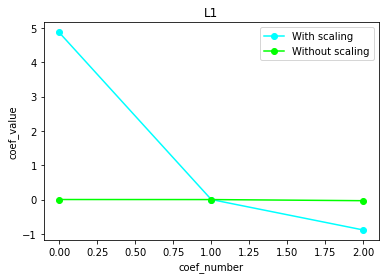

In [47]:
plt.plot(l1_coef_with_scaling, color=(0, 1, 1), marker='o', label='With scaling')
plt.plot(l1_coef_without_scaling, color=(0, 1, 0), marker='o', label='Without scaling')
plt.xlabel("coef_number")
plt.ylabel("coef_value")
plt.title('L1')
plt.legend()

plt.show()

#### L2

*With scaling*

In [48]:
X_train, X_valid, y_train, y_valid = train_test_split(X_hw, y_hw, test_size=0.3, random_state=SEED)
reg = make_model_without_polynom(10, alpha=0.5, penalty='L2').fit(X_train, y_train)
l2_coef_with_scaling = reg['reg'].coef_

In [49]:
l2_coef_with_scaling

array([ 5.2614121 , -0.30600317, -1.32619101])

*Without scaling*

In [50]:
X_train, X_valid, y_train, y_valid = train_test_split(X_hw, y_hw, test_size=0.3, random_state=SEED)
reg = make_model_without_polynom_and_scaling(10, alpha=0.5, penalty='L2').fit(X_train, y_train)
l2_coef_without_scaling = reg['reg'].coef_

In [51]:
l2_coef_without_scaling

array([ 1.05507290e+01, -1.42204188e-03, -3.40800474e-02])

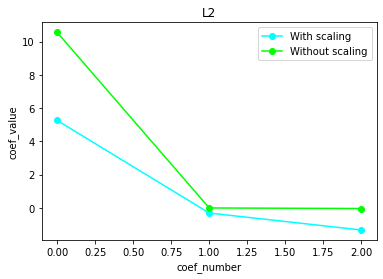

In [52]:
plt.plot(l2_coef_with_scaling, color=(0, 1, 1), marker='o', label='With scaling')
plt.plot(l2_coef_without_scaling, color=(0, 1, 0), marker='o', label='Without scaling')
plt.xlabel("coef_number")
plt.ylabel("coef_value")
plt.title('L2')
plt.legend()

plt.show()

#### Summary



*The plots demonstrate that the coefficients with scaling have smaller range than the coefficients without scaling. The biggest difference can be seen for the first ones.*

Is scaling important? What are the underlying reasons? *Scaling is very important for the datasets in which features have different ranges. For example, in this task the first feature has its values in range (-0.05; 0.05), the second one varies from about -494.87 to 493.57 (the values can be different in different runs of the notebook) and the last one varies from about -2.35 to 213.31. Without scaling the features have completely different weight. Scaling allows to avoid the domination of the features with the big range.*